✓ link to download the data set: [Link](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv)  
✓ link for the description of each column of the dataset [Link](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names)

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scipy
import itertools
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from ipywidgets import interact
import warnings
from tqdm import tqdm
%matplotlib inline

In [5]:
# Changing the current directory
os.chdir('G:\My Drive\Career\IBM certificate\Database')

In [6]:
# reading the csv file using Pandas library
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv"
df = pd.read_csv(url, header=None) # storing the csv file in a data frame named df

In [7]:
# add header manually to df
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
df.columns = headers

## Preliminary conversion

In [8]:
# thic converts mile per gallon to km per liter
df['city-mpg']=df['city-mpg']*0.425144
df['highway-mpg']=df['highway-mpg']*0.425144

## Missing values
In this section missing values are identified and replaced with appropriate values. 

In [9]:
df.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,8.928024,11.478888,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,8.928024,11.478888,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,8.077736,11.053744,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,10.203456,12.754320,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,7.652592,9.353168,17450


**Discussion**: Looking at the data frame header above shows there are a few cells with "?" as value. These cells should be replaced with none values using numpy.nan.

In [10]:
# replace the missing values with np.nan
df = df.replace('?',np.nan)

In [11]:
# we can now count the number of missing values
df_nan = df.isnull()
column_with_nan = []
for column in df_nan.columns.values.tolist():
    if True in df_nan[column].values:
        print(column.upper(),":" , df_nan[column].value_counts(),'\n')
        column_with_nan.append(column)
column_with_nan

NORMALIZED-LOSSES : False    164
True      41
Name: normalized-losses, dtype: int64 

NUM-OF-DOORS : False    203
True       2
Name: num-of-doors, dtype: int64 

BORE : False    201
True       4
Name: bore, dtype: int64 

STROKE : False    201
True       4
Name: stroke, dtype: int64 

HORSEPOWER : False    203
True       2
Name: horsepower, dtype: int64 

PEAK-RPM : False    203
True       2
Name: peak-rpm, dtype: int64 

PRICE : False    201
True       4
Name: price, dtype: int64 



['normalized-losses',
 'num-of-doors',
 'bore',
 'stroke',
 'horsepower',
 'peak-rpm',
 'price']

**Discussion**: The number of missing values are highest in the normalized-losses column (around 25%). These cells should be replaced by a value which represents the rest of data. The list of columns with missing values are also provided above.

#### Replacing the missing values with average value

In [12]:
# all the columns with missing values are assigned to the data frame df_with_nan
df_with_nan=pd.DataFrame()
for a in column_with_nan:
    df_with_nan[a]=df[a]
df_with_nan.head(4)

,normalized-losses,num-of-doors,bore,stroke,horsepower,peak-rpm,price
0,NaN,two,3.47,2.68,111,5000,13495
1,NaN,two,3.47,2.68,111,5000,16500
2,NaN,two,2.68,3.47,154,5000,16500
3,164,four,3.19,3.40,102,5500,13950


**Discussion**: The data frame with missing values (df_with_nan) includes columns with numeric values and object data type (only one column has object data type).

In [13]:
df_with_nan['num-of-doors'].unique()

array(['two', 'four', nan], dtype=object)

**Discussion**: There are two types of values (two and four) in the column num-of-doors. let's count the number of each value type.

In [14]:
door_value_count = df_with_nan['num-of-doors'].value_counts()
print(door_value_count)
print(f"number of missing values is equal to {205-door_value_count[0]-door_value_count[1]}")

four    114
two      89
Name: num-of-doors, dtype: int64
number of missing values is equal to 2


**Discussion**: Only 2 values are missing values. These two values will be replaced by four which has the highest frequency in the column.

In [15]:
df_with_nan['num-of-doors'].replace(np.nan,'four',inplace=True)
column_with_nan.remove('num-of-doors')
print(column_with_nan)

['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']


**Discussion**: The null values in the column num-of-doors are replaced with 'four' and this element is removed from the list column_with_nan. For the remaining elements in the list,the missing values are replaced with the average values of the column. The code is presented in the cell below. 

In [16]:
for column in column_with_nan:
    df[column] = df[column].astype('float') # change the data type to float
    normalized_not_null = df[df[column].notnull()][column] # filter only the not null values
    normalized_not_null_avg = normalized_not_null.mean() # find the average value of the column
    df[column].replace(np.nan,normalized_not_null_avg, inplace=True) # replace the missing value with the average value

**Discussion**: All the missing values in the data frame df are replaced with an appropriate value

## Normalizing dataframe

Normalizing the columns that have different ranges of numerical data helps the accuracy of the machine learning models.

In [17]:
# let's find the columns with non object type values
column_not_object = []
for d in df.columns:
    if df[d].dtype!=object:
        column_not_object.append(d)

In [18]:
df_max_not_object=[]
df_min_not_object=[]
for e in column_not_object:
    df_max_not_object.append(df[e].max())
    df_min_not_object.append(df[e].min())
df_max_min = pd.DataFrame({'column name':column_not_object,'min':df_min_not_object,'max':df_max_not_object})
df_max_min

,column name,min,max
0,symboling,-2.000000,3.000000
1,normalized-losses,65.000000,256.000000
2,wheel-base,86.600000,120.900000
3,length,141.100000,208.100000
4,width,60.300000,72.300000
5,height,47.800000,59.800000
6,curb-weight,1488.000000,4066.000000
7,engine-size,61.000000,326.000000
8,bore,2.540000,3.940000
9,stroke,2.070000,4.170000


**Discussion**: The results above shows that data ranges are differently distributed in different columns. For instance the curb-weight and peak-rpm columns have significantly higher data range compared to other feature variables. Let's normalize these two columns.

In [19]:
def normalize_column(col_name):
    df[col_name] = (df[col_name]-df[col_name].mean())/df[col_name].std() # (data-mean(column))/std(column)
##
normalize_column('curb-weight')
normalize_column('peak-rpm')
df[['curb-weight','peak-rpm']].head(5)

,curb-weight,peak-rpm
0,-0.014531,-0.262841
1,-0.014531,-0.262841
2,0.513625,-0.262841
3,-0.419770,0.785423
4,0.515545,0.785423


<AxesSubplot:xlabel='curb-weight', ylabel='peak-rpm'>

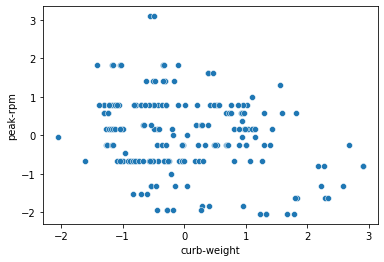

In [20]:
%%capture --no-display 
sns.scatterplot(df['curb-weight'],df['peak-rpm'])

**Discussion**: The scatter plot above shows the normalized range of columns curb-weight and peak-rpm which almost between -3 and 3.

## Binning
Let's group the price column to 3 categories including low, medium, and max.

In [21]:
df['price'] =  df['price'].astype('float')
price = df['price']
bins = np.linspace(min(price),max(price),4)
group_name = ('low', 'medium' , 'high')
df['price_binned']= pd.cut(df['price'] , bins, labels=group_name, include_lowest=True)

Text(0.5, 1.0, 'Price categories')

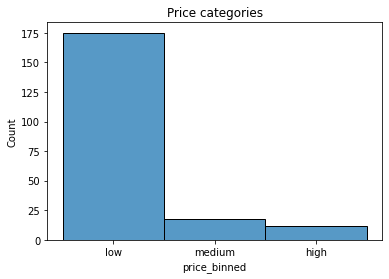

In [22]:
%%capture --no-display 
sns.histplot(df['price_binned'])
plt.title('Price categories')

**Discussion**: The plot above shows that the low priced cars (max low priced car <= 33% max car price) have higher population. The other two categories have similar number of data.The number of data in each category is presented below.

In [23]:
df_bin_count = df['price_binned'].value_counts().to_frame()
df_bin_count.rename(columns={'price_binned':'count_value'},inplace=True)
df_bin_count.index.name='price_category'
df_bin_count = df_bin_count.reset_index()
df_bin_count

,price_category,count_value
0,low,175
1,medium,18
2,high,12



## Descriptive statistic analysis:
### Continuous variables
Extracting the correlation between variables  

<AxesSubplot:>

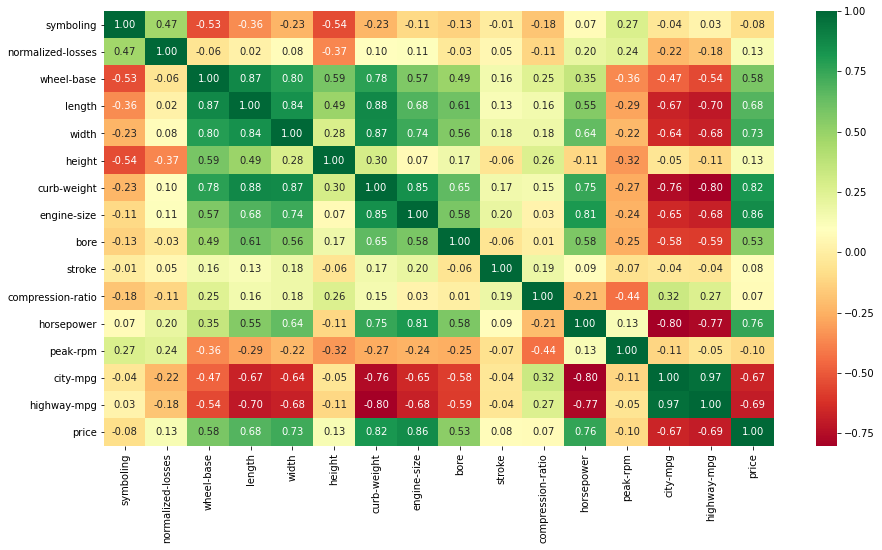

In [24]:
df_corr = df.corr() # extracting the correlation coefficient of all the continuous variables
fig, ax=plt.subplots(figsize=(15,8))
sns.heatmap(df_corr,annot=True,fmt='.2f',ax=ax,cmap='RdYlGn') # heatmap plot on corr coeffs to display what variables have siginficiant corr coeff

**Discussion**: From the heatmap plot above, it could be concluded that it is likely that the below variables are not strong predictive features for the target variable "price" ("i.e., these variables could be excluded in the machine learning model"):   
*symbolling, normalized-losses, height, stroke, compression-ration, peak-rpm*

Furthermore, the heatmap plot shows that the **engine-size** is potentially the best predictive feature for the target variable price.

Let's plot linear regression lines for engine-size (with highest corr coeff) and stroke (with lowest corr coeff).

In [25]:
def plot_regression(x,y,w,h): # plotting the linear regression and deriving the correlation coefficient for x and y 
    fig, ax=plt.subplots(figsize=(w,h))
    df_limit = df[[x,y]]
    plt.scatter(x ,y,data=df_limit)
    pr = scipy.stats.pearsonr(df[x],df[y]) # pearsonr method is employed to obtain the cor coeff and p_value
    plt.title(f'Corr coeff and p_value for {x} and {y} are equal to \n' + str(round(pr[0],3))+" and "+str(pr[1]))
    sns.regplot(x ,y,data=df_limit) # finding the linear regression between the feature variable and target variable

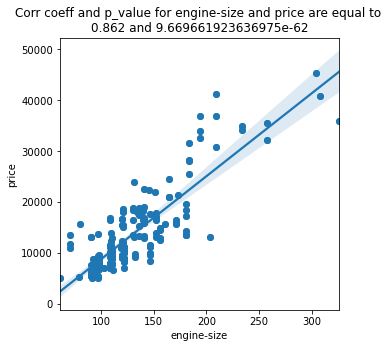

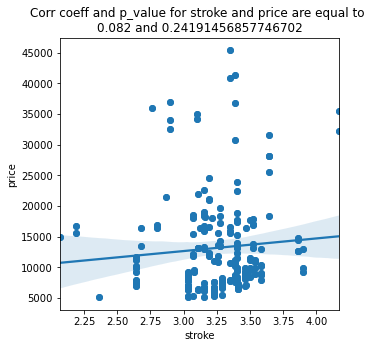

In [26]:
%%capture --no-display 
# The above magic command is used to prevent displying the warning messages
y = 'price' # target variale
w = 5 # width of the box plot
h = 5 # height of the box plot
plot_regression('engine-size',y,w,h)
plot_regression('stroke',y,w,h)

**Discussion**: The plots above shows that as expected the engine-size has a strong positive correlation with the target variable, and stroke has a very small positive correlation with price. Hence, the latter feature may not be a good predictive feature for the price variable. In order to find the strength of the dependency p_value could be extracted using pearsonr method in scipy library as shown in the title of the above plots and also presented below.

In [27]:
A='engine-size'
B='price'
corr_coeff,pearson_value =  scipy.stats.pearsonr(df[A],df[B])
print(f'correlation coefficient for {A} and {B} = {corr_coeff}')
print(f'pearson value for {A} and {B} = {pearson_value}')

correlation coefficient for engine-size and price = 0.8617522436859719
pearson value for engine-size and price = 9.669661923636975e-62


**Discussion**: Since the p value presented above is smaller than 0.001, the correlation between price and engine-size is strong and the null hypothesis could be rejected.


### Categorical variables
Association between variables

In [28]:
# let's first describe the object features
df.describe(include='object')

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
count,205,205,205,203,205,205,205,205,205,205
unique,22,2,2,2,5,3,2,7,7,8
top,toyota,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,32,185,168,114,96,120,202,148,159,94


**Discussion**: It seems to me that the feature make is a good predictive feature since it has a highest number of unique values. 

Firstly, let's check the **analysis of variance (ANOVA)** showing if there is a large difference between two or more groups within the feature variable make.

In [29]:
unique_make_list = [] # this creats a list of unique elements within the column make
for b in df['make'].unique():
    unique_make_list.append(b)

In [30]:
unique_make_comb = [] # this provides all the combinations of elements within unique_make_list with the length equal to 2
for m in itertools.combinations(unique_make_list,2):
    unique_make_comb.append(m)

In [31]:
# let's group the data frame with columns make and price based on the column make
df_make_price = df[['make','price']]
df_make_price_gr = df_make_price.groupby('make')

In [32]:
def ANOVA(x,y): # this extracts prices of unique categories (e.g., mazda) within the column "make"
    return df_make_price_gr.get_group(unique_make_comb[x][y])['price']

In [33]:
# Let's analyze the variance of every two unique make categories
ANOVA_values=[]
ANOVA_colname=[]
for c in range(len(unique_make_list)):
    ANOVA_colname.append(unique_make_comb[c])
    ANOVA_values.append(scipy.stats.f_oneway(ANOVA(c,0),ANOVA(c,1))[0:2]) 
df_ANOVA= pd.DataFrame(ANOVA_values,ANOVA_colname)
df_ANOVA.columns=['F-test-score','p-value']
df_ANOVA

,F-test-score,p-value
"(alfa-romero, audi)",0.574333,0.470275
"(alfa-romero, bmw)",3.650348,0.088378
"(alfa-romero, chevrolet)",75.508276,0.000966
"(alfa-romero, dodge)",28.917573,0.000311
"(alfa-romero, honda)",32.008671,0.000059
"(alfa-romero, isuzu)",5.033665,0.074877
"(alfa-romero, jaguar)",151.977750,0.000249
"(alfa-romero, mazda)",4.162180,0.056287
"(alfa-romero, mercedes-benz)",19.676220,0.001633
"(alfa-romero, mercury)",0.251500,0.665780


**Discussion**: The first columns shows the F-test-score displaying how much difference there is between the means of different categories of auto make. The second columns shows the p-value indicating how statistically significant the F-test-score is. If the price is strongly correlated with the feature variable make, then we expect to see high f-score and low p-value. For instance, the price of BMW and Audi cars are similar as both are from German companies and both are fairly expensive. As such, the F-score is expected to be small and p-value is expected to be quite large for a BMW and Audi. The data frame above confirms this expectation (F-score=5.69, p-value=0.033).

In [34]:
# filtering all the combincations with p-value smaller than 0.001
df_ANOVA[df_ANOVA['p-value']<0.001]

,F-test-score,p-value
"(alfa-romero, chevrolet)",75.508276,0.000966
"(alfa-romero, dodge)",28.917573,0.000311
"(alfa-romero, honda)",32.008671,0.000059
"(alfa-romero, jaguar)",151.977750,0.000249
"(alfa-romero, subaru)",31.840225,0.000080


**Discussion**: The above data frame shows the categories of car types with p-values less than 0.001. For instance Mazda and Mercedes-benz have very small p-values and high f-scores which make sense as benz cars are very expensive and Maza cars are quite inexpensive. The box plot below shows the mean price values of mazda versus benz auto make.

<AxesSubplot:title={'center':'Price distribution of mazda versus mercedes-benz cars'}, xlabel='make', ylabel='price'>

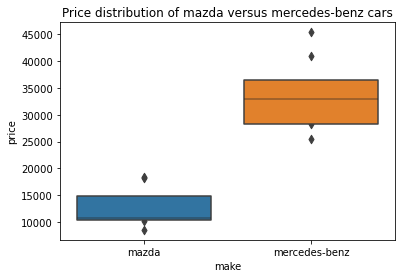

In [35]:
%%capture --no-display 
df_limit=df.iloc[60:75,:]
plt.title('Price distribution of mazda versus mercedes-benz cars')
sns.boxenplot(df_limit['make'],df_limit['price'])

**Discussion**: The box plot above shows the significantly different mean values for the price of Mazda cars versus Benz cars which cofirms the very small p-value presented above.

Now, let's check the **association** between variables to predict price using Chi square.

In [36]:
def chi_square(var1,var2):    
    df_price_make = df[[var1,var2,'price']]
    df_price_make_gr = df_price_make.groupby([var1,var2],as_index=False).mean()
    df_price_make_pivot = df_price_make_gr.pivot(index=var1,columns=var2)
    df_price_make_pivot.fillna(0,inplace=True)
    chi_square = scipy.stats.chi2_contingency(df_price_make_pivot,correction=True)
    return chi_square[0:3]

In [37]:
col_obj=[] # this list collects all the columns with object data type
for d in df.columns:
    if df[d].dtype=='object':
        col_obj.append(d)

In [38]:
col_obj_comb = [] # this list provides all the combinations of elements within col_obj list with the length equal to 2
for k in itertools.combinations(col_obj,2):
    col_obj_comb.append(k)

In [39]:
# let's analyze the association (i.e., chi-square and p-value) between differnt object type features using chi-square method
for f in range(len(col_obj_comb)):
    print(col_obj_comb[f],chi_square(col_obj_comb[f][0],col_obj_comb[f][1]))

('make', 'fuel-type') (147215.58979607973, 0.0, 21)
('make', 'aspiration') (160469.50132348516, 0.0, 21)
('make', 'num-of-doors') (94434.61754396914, 0.0, 21)
('make', 'body-style') (759904.188260034, 0.0, 84)
('make', 'drive-wheels') (444961.6142674795, 0.0, 42)
('make', 'engine-location') (221483.97554222212, 0.0, 21)
('make', 'engine-type') (1622680.2512554568, 0.0, 126)
('make', 'num-of-cylinders') (1567580.0907568969, 0.0, 126)
('make', 'fuel-system') (1490366.9111146408, 0.0, 147)
('fuel-type', 'aspiration') (988.7794997522026, 4.934145320291949e-217, 1)
('fuel-type', 'num-of-doors') (43.18101780588942, 4.9902478409148475e-11, 1)
('fuel-type', 'body-style') (24964.396519668997, 0.0, 4)
('fuel-type', 'drive-wheels') (9692.28436059937, 0.0, 2)
('fuel-type', 'engine-location') (25724.157926953172, 0.0, 1)
('fuel-type', 'engine-type') (60403.43008971685, 0.0, 6)
('fuel-type', 'num-of-cylinders') (72602.66461179515, 0.0, 6)
('fuel-type', 'fuel-system') (95660.87706743521, 0.0, 7)
('as

**Discussion**: The chi square values above indicate for all combination of object type feature variables reject the null hypothesis (i.e., p-value is smaller than 0.001).

## Predictive Analysis

### Filtering the independent variables
The model do not need to be trained against all the independent variables. Let's only use the independent variables with correlation coefficients more than 0.5

In [40]:
df_cor = df.corr().loc['price'].to_frame()
cor_list = df_cor[df_cor['price']>0.5].index.to_list()
cor_list.remove('price')
print(cor_list) # list of features with correlation variable more than 0.5

['wheel-base', 'length', 'width', 'curb-weight', 'engine-size', 'bore', 'horsepower']


In [41]:
df_cor[df_cor['price']>0.5].sort_values(by='price').tail(5)
# the data frame below shows that the engine-size, curb-weight and horsepower have the highest correlation coefficients.

,price
width,0.728699
horsepower,0.757917
curb-weight,0.820825
engine-size,0.861752
price,1.000000


**Discussion**: As shown above engine-size has the highest correlation coefficient. However, I have a better sense about the horsepower instead. As such, let's built the simple linear regression model for this variable.

### In sample testing
The first step in a predictive analysis is to split the data into train and test. The train data which is around 70% of the data is used to train the model and test data is used to test the model.

In [42]:
x_data_total = df[cor_list] # all the independent variables
y_data_total = df['price'] # the target variable

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x_data_total, y_data_total, test_size=0.33, random_state=0)

### Simple linear regression
#### Building the model

In [44]:
lm_lr=LinearRegression() # creating a linear regression object
lm_lr.fit(x_train[['horsepower']],y_train) # train the model
intercept=lm_lr.intercept_
coeff=lm_lr.coef_
print(f'price(hat) = {round(intercept,3)} + {round(coeff[0],3)} * independent_var')

price(hat) = -4377.502 + 170.594 * independent_var


#### Visualisations

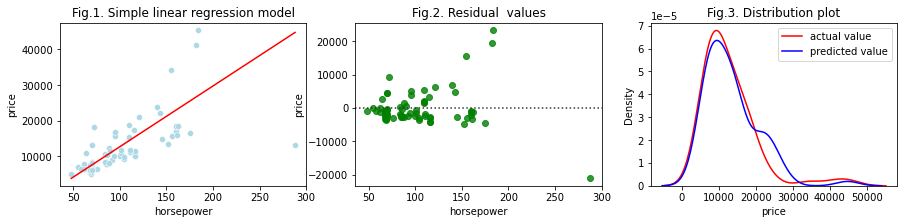

In [45]:
%%capture --no-display 
# Plotting the simple regression model
fig, ax = plt.subplots(1,3,figsize = (15,3))
yhat_lr=lm_lr.predict(x_test[['horsepower']])
sns.scatterplot(x_test['horsepower'],y_test, color='lightblue',ax = ax[0])
sns.lineplot(x_test['horsepower'],yhat_lr, color='red', ax = ax[0])
ax[0].set_title('Fig.1. Simple linear regression model')
## Plotting the residual values
sns.residplot(x_test[['horsepower']],y_test,color='green',ax = ax[1])
ax[1].set_title('Fig.2. Residual  values')
## Distribution plot
yhat_lr=lm_lr.predict(x_test[['horsepower']])
sns.distplot(y_test, hist=False,color='r',label="actual value",ax = ax[2])
sns.distplot(yhat_lr, hist=False,color='blue',label="predicted value",ax = ax[2])
ax[2].set_title('Fig.3. Distribution plot')
ax[2].legend()

**Discussion**: Figure 1 shows that the linear regression line passes through a reasonable proportion of data. Also, the distribution of residual values are almost symmetrical with respect to 0 axis (Figure 2). As such, the linear regression assumption is nearly accurate. Furthermore, the distribution plot above shows that the predictive model provides good estimation all along the price range. However it could be improved, for instance by using more than one independent variables+.

### Multi-linear regression model
#### Building a model with 7 independent variables with correlation coefficients more than 0.5

In [46]:
lm_mr = LinearRegression()
lm_mr.fit(x_train[cor_list],y_train) # cor_list includes all the columns names that their correlation coefficients with price is more than 0.5
intercept_multi=lm_mr.intercept_
coeff_multi=lm_mr.coef_
print(f"""price(hat) = {round(intercept_multi,3)}+({round(coeff_multi[0],3)}*{cor_list[0]})+({round(coeff_multi[1],3)}*{cor_list[1]})+
      ({round(coeff_multi[2],3)}*{cor_list[2]})+({round(coeff_multi[3],3)}*{cor_list[3]})+({round(coeff_multi[4],3)}*{cor_list[4]})+
      ({round(coeff_multi[5],3)}*{cor_list[5]})+({round(coeff_multi[6],3)}*{cor_list[6]})""")

price(hat) = -41765.233+(27.086*wheel-base)+(-65.335*length)+
      (706.622*width)+(1382.006*curb-weight)+(77.236*engine-size)+
      (322.444*bore)+(59.996*horsepower)


#### Visualisations

Text(0.5, 1.0, 'Distribution plots')

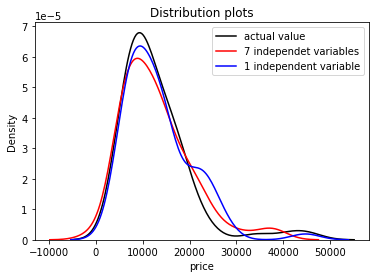

In [47]:
%%capture --no-display 
# For the multi-linear regression model as the number of independent variables are 7, only the distribution plot is displayed.
yhat_mlr = lm_mr.predict(x_test[cor_list])
sns.distplot(y_test, hist=False,color='black',label="actual value")
sns.distplot(yhat_mlr, hist=False,color='red',label="7 independet variables")
sns.distplot(yhat_lr, hist=False,color='blue',label="1 independent variable")
plt.legend()
plt.title('Distribution plots')

**Discussion**: The distribution plot above shows that the accuracy of the predictive model has enhanced by increasing the number of independent variables from 1 to 7. The enhancement occurs mainly around price range of \\$20k-$30k. Now let's examine the accuracy of the predictive model using polynomial regression.

### Polynomial regression model - 1 dimension

*The data evaluation methods such as R square and Mean Square Errors (MSE) will be discussed in following sections. However, these methods are used to find the most optimum order of the 1-d polynomial model.*

Text(0, 0.5, 'MSE')

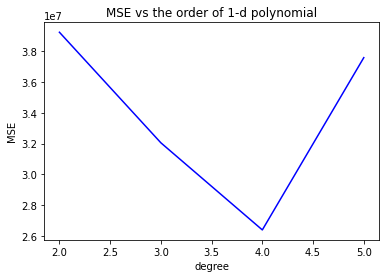

In [103]:
%%capture --no-display 
# Sensitivity study on the order of 1 dimensional polynomial based on MSE
mse_1d_poly_list = []
degree = []
def poly_deg(var):
    for deg in range(2,6):
        input = [('polynomial',PolynomialFeatures(degree=deg)),('model',LinearRegression())]
        pipe = Pipeline(input)
        pipe.fit(x_train[var],y_train)
        y_hat = pipe.predict(x_test[var])
        mse_1d_p = mse(y_hat, y_test)
        mse_1d_poly_list.append(round(mse_1d_p,3))
        degree.append(deg)
    return mse_1d_poly_list
poly_deg(['horsepower'])
sns.lineplot(degree,mse_1d_poly_list, color='b')
plt.title('MSE vs the order of 1-d polynomial')
plt.xlabel('degree')
plt.ylabel('MSE')

**Discussion**: The plot above shows the change in the mean square error (mse) value for varied range of degree of the 1 dimensional polynomial regression model (degree=2-6). According to the plot, the degree equal to 4 provides the lowest mse value.

Text(0, 0.5, 'R square')

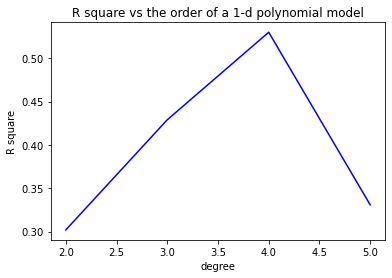

In [102]:
%%capture --no-display 
# Sensitivity on the order of 1 dimensional polynomial regression model based on R square
R2_1d_poly_list = []
degree = []
def poly_deg(var):
    for deg in range(2,6):
        input = [('polynomial',PolynomialFeatures(degree=deg)),('model',LinearRegression())]
        pipe = Pipeline(input)
        pipe.fit(x_train[var],y_train)
        score_1d_pr = pipe.score(x_test[var],y_test)
        R2_1d_poly_list.append(round(score_1d_pr,3))
        degree.append(deg)
    return R2_1d_poly_list
poly_deg(['horsepower'])
sns.lineplot(degree,R2_1d_poly_list, color='b')
plt.title('R square vs the order of a 1-d polynomial model')
plt.xlabel('degree')
plt.ylabel('R square')

**Discussion**: The plot above shows the change in the R square value for varied range of degree of the 1 dimensional polynomial regression model (degree= 2-6). According to the plot, the degree equal to 4 provides the highest R square value which is 75%. This findings is aligned with the mse results presented above. Therefore, the order of the 1-d polynomial model for the base case scenario is considered equal to 4.

#### Building the model

In [105]:
# 1 dimension polynomial regression
warnings.filterwarnings('ignore')
def poly(deg):
    input = [('polynomial',PolynomialFeatures(degree=deg)),('model',LinearRegression())]
    pipe = Pipeline(input)
    pipe.fit(x_train[['horsepower']],y_train)
    fig, ax = plt.subplots(figsize=(6,3))
    yhat = pipe.predict(x_test[['horsepower']])
    sns.lineplot(x_test['horsepower'], yhat,color='red',ax=ax)
    sns.scatterplot(x_test['horsepower'], y_test,color='lightblue',ax=ax)
    plt.title('Fig.1. Polynomial regression model')
interact(poly, deg=(1,6))

interactive(children=(IntSlider(value=3, description='deg', max=6, min=1), Output()), _dom_classes=('widget-in…

<function __main__.poly(deg)>

**Discussion**: Using the function interact, several orders of the polynomial model could be displayed by moving the above circle to the right and left. As presented before, the order of 4 leads to highest accuracy (R square) which is evident in the plot above.

In [150]:
# let's build the model with the degree of 4
input = [('polynomial',PolynomialFeatures(degree=4)),('model',LinearRegression())]
pipe_poly = Pipeline(input)
pipe_poly.fit(x_train[['horsepower']],y_train)
print(f"The intercept is {round(pipe_poly.named_steps['model'].intercept_,3)}")
print(f"The coefficients are {pipe_poly.named_steps['model'].coef_}")

The intercept is -11482.45
The coefficients are [ 0.00000000e+00  4.94995562e+02 -4.76635324e+00  2.71252322e-02
 -5.13871880e-05]


#### Visualisations

Text(0.5, 1.0, 'Fig.2. Distribution plot')

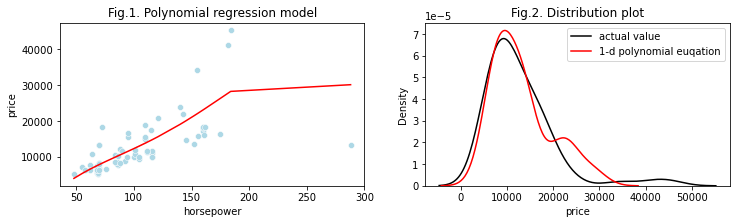

In [151]:
%%capture --no-display 
## Plotting the 1  dimensional polynomial regression model
fig, ax = plt.subplots(1,2,figsize=(12,3))
pipe_poly.fit(x_train[['horsepower']],y_train)
yhat_1d_pr = pipe_poly.predict(x_test[['horsepower']])
sns.lineplot(x_test['horsepower'], yhat_1d_pr,color='red',ax=ax[0])
sns.scatterplot(x_test['horsepower'], y_test,color='lightblue',ax=ax[0])
ax[0].set_title('Fig.1. Polynomial regression model')
## Distribution plot
sns.distplot(y_test, hist=False,color='black',label="actual value",ax=ax[1])
sns.distplot(yhat_1d_pr, hist=False,color='red',label="1-d polynomial euqation",ax=ax[1])
ax[1].legend()
ax[1].set_title('Fig.2. Distribution plot')

**Discussion**: Figure 1 shows the polynomial regression model which accounts for the nonlinearity of the data values. Figure 2 shows the distributions plot indicating that there is a good agreement between the predicted and actual values except in the range between \\$20k to $30k.

### Polynomial regression model - multi-dimension
#### Building the model

In [122]:
def ml_lr_fit(deg):
    input = [('polynomial',PolynomialFeatures(degree=deg)),('model',LinearRegression())]
    pipe = Pipeline(input)
    pipe.fit(x_train[cor_list],y_train)
    yhat_md_pr = pipe.predict(x_test[cor_list])
    return yhat_md_pr

#### Visualisation

Text(0.5, 1.0, 'Distribution plot')

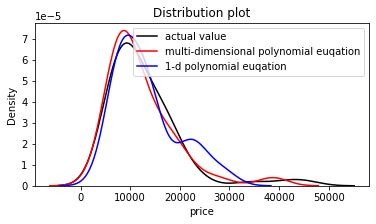

In [123]:
%%capture --no-display 
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(y_test, hist=False,color='black',label="actual value",ax=ax)
sns.distplot(ml_lr_fit(2), hist=False,color='red',label="multi-dimensional polynomial euqation",ax=ax)
sns.distplot(yhat_1d_pr, hist=False,color='blue',label="1-d polynomial euqation",ax=ax)
plt.legend()
plt.title('Distribution plot')

**Discussion**: Based on the plot shown above, the 1-d polynomial equation provides a better prediction compared to the multi dimensional polynomial model in the lower price range. The opposite statement could be seen for the price range between \\$20k to $35k. Let's check the multi dimensional polynomial model with higher orders (e.g., 3).

Text(0.5, 1.0, 'Distribution plot')

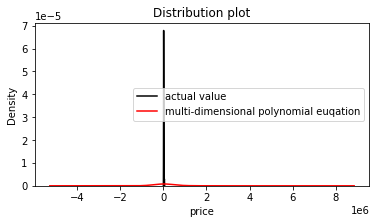

In [124]:
%%capture --no-display 
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(y_test, hist=False,color='black',label="actual value",ax=ax)
sns.distplot(ml_lr_fit(3), hist=False,color='red',label="multi-dimensional polynomial euqation",ax=ax)
plt.legend()
plt.title('Distribution plot')

**Discussion**: The plot above shows that using the multi dimensional polynomial model with the order equal to 3 leas to overfitting. Let's use ridge regression to remove the dependency of the model to outliers.

### Ridge Regression

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10024.63it/s]

best_estimator is Ridge(alpha=10, normalize=True)


Text(0, 0.5, 'Mean R-square_test data')

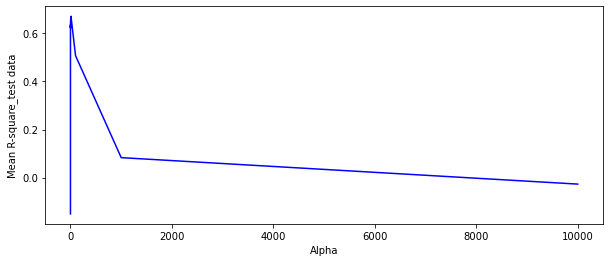

In [74]:
# before creating the ridge model, let's find the alpha parameter in the Ridge model which leads to the highest R square.
# R square will be further discussed under the model evaluation section
alpha=[]
deg = 3
for A in range(-5,5):
    alpha.append(10**A)
##
parameter = {'alpha':alpha,'normalize':[True]}
grid1 = GridSearchCV(Ridge(),parameter,cv=4)
grid1.fit(PolynomialFeatures(degree=deg).fit_transform(x_data_total[cor_list]),y_data_total)
print(f'best_estimator is {grid1.best_estimator_}')
mean_test_score = grid1.cv_results_['mean_test_score']
##
c=0
mean_test_score_list = []
for _ in range(len(mean_test_score)):
    if c<len(mean_test_score):
        for B in tqdm(alpha):
            mean_test_score_list.append(round(mean_test_score[c],3))
            c=c+1
##
fig, ax = plt.subplots(figsize = (10,4))
sns.lineplot(alpha,mean_test_score_list, ax=ax, color='blue')
plt.xlabel('Alpha')
plt.ylabel('Mean R-square_test data')

**Discussion**: The analyses above shows that using the alpha value equal to 10 where the values are normalized leads to the highest R square (0.67). Hence this value is used in the Ridge model.

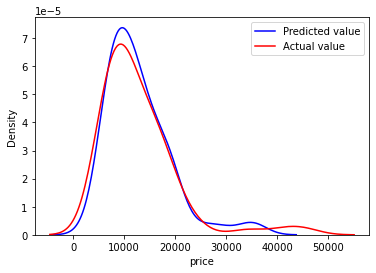

In [158]:
%%capture --no-display 
deg = 3
input_ridge = [('polynomial',PolynomialFeatures(degree=deg)),('model',Ridge(alpha=10, normalize=True))]
pipe_ridge = Pipeline(input_ridge)
pipe_ridge.fit(x_train[cor_list],y_train)
yhat_ridge = pipe_ridge.predict(x_test[cor_list])
sns.distplot(yhat_ridge, hist=False, label='Predicted value', color='blue')
sns.distplot(y_test, hist=False, label='Actual value', color='red')
plt.legend()

**Discussion**: The plot above shows that using ridge regression could resolve the overfitting issue with higher order of multi dimensional polynomial regression model leading to an excellent match between the predictive curve and actual values. Hence, ridge model is employed instead of multi-dimensional polynomial model for the model evaluation. let's find the most optimum value of the parameter alpha using GridSearchCV.

## Model evaluation
Let's evaluate the regression model developed above using **mean square error (MSE)** and **R square (also known as the coefficient of determination**.

#### Mean Square Error (MSE)

<AxesSubplot:xlabel='Models', ylabel='MSE'>

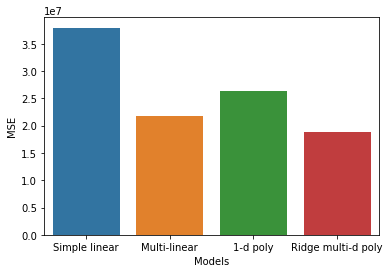

In [148]:
%%capture --no-display
mse_lr = mse(yhat_lr,y_test)## simple regression model
mse_mlr = mse(yhat_mlr,y_test) ## multi-linear regression model
mse_p = mse(yhat_1d_pr,y_test)## 1-dimensional polynomial regression model
mse_mp_ridge = mse(yhat_ridge,y_test)## Ridge polynomial regression model 
##
df_mse = pd.DataFrame({'MSE':[mse_lr,mse_mlr,mse_p,mse_mp_ridge],'Models':['Simple linear','Multi-linear','1-d poly','Ridge multi-d poly']})
sns.barplot(df_mse['Models'], df_mse['MSE'])

**Discussion**: The comparison of MSE for 4 regression models indicates that using the ridge multi-dimensional polynomial and multi-linear model lead to the similar and favorable results and the simple linear model has the highest MSE.

#### R square (also known as the coefficient of determination)

**Discussion**: The comparison of R square for 4 regression models indicates that using the ridge multi-dimensional polynomial and multi-linear models leads to the similar and favorable results and the simple linear model has the lowest r square.

#### Cross validation

In [ ]:
%%capture --no-display
cv=4
## simple regression model
mean_score_lr= cross_val_score(LinearRegression(), x_data_total[['horsepower']], y_data_total, cv=cv)
print(f"The mean R square value for the simple regression model : {round(mean_score_lr.mean(),3)}")
## multi-linear regression model
mean_score_mr= cross_val_score(LinearRegression(), x_data_total, y_data_total, cv=cv)
print(f"The mean R square value for the multi-linear regression model : {round(mean_score_mr.mean(),3)}")
## 1 dimensional polynomial regression model
mean_score_1p= cross_val_score(LinearRegression(), PolynomialFeatures().fit_transform(x_data_total[['horsepower']]), y_data_total, cv=cv)
print(f"The mean R square value for the 1 dimensional polynomial regression model : {round(mean_score_1p.mean(),3)}")
## multi dimensional polynomial regression model
mean_score_mp_ridge= cross_val_score(Ridge(), PolynomialFeatures().fit_transform(x_data_total[cor_list]), y_data_total, cv=cv)
print(f"The mean R square value for the multi dimensional polynomial regression model : {round(mean_score_mp_ridge.mean(),3)}")
##
df_r2_cross = pd.DataFrame({'r2_cross':[mean_score_lr.mean(),mean_score_mr.mean(),mean_score_1p.mean(),mean_score_mp_ridge.mean()],'Models':['Simple linear','Multi-linear','1-d poly','multi-d poly']})
sns.lineplot(df_r2_cross['Models'], df_r2_cross['r2_cross'], color='red',label='Cross examination')
sns.lineplot(df_r2['Models'], df_r2['r2'], color='blue',label='R square value')
# plt.legend()

**Discussion**: The mean R square values obtained from cross examination are significantly different for 1-d polynomial model and moderately different for simple linear and ridge models compared to the values obtained from in-sample testing. However, the R square values for multi linear model is almost the same indicating that the multi-linear model is more consistent and reliable.

In [ ]:
%%capture --no-display
##
fig, ax = plt.subplots(2,2,figsize = (9,6))
fig.tight_layout(pad=4.0)
##
mean_yhat= cross_val_predict(LinearRegression(), x_data_total[['horsepower']], y_data_total, cv=3)
sns.distplot(y_data_total,hist=False, color='lightblue', label='actual value',ax=ax[0,0])
sns.distplot(mean_yhat, hist=False, color='red', label='predicted value', ax=ax[0,0])
ax[0,0].legend()
ax[0,0].set_xlabel('Horsepower')
ax[0,0].set_title('Fig.1. Simple linear regression')
##
mean_yhat= cross_val_predict(LinearRegression(), x_data_total[cor_list], y_data_total, cv=3)
sns.distplot(y_data_total,hist=False, color='lightblue', label='actual value',ax=ax[0,1])
sns.distplot(mean_yhat, hist=False, color='red', label='predicted value', ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_xlabel('Multiple variable')
ax[0,1].set_title('Fig.2. Multi-linear regression')
##
mean_yhat= cross_val_predict(LinearRegression(), PolynomialFeatures().fit_transform(x_data_total[['horsepower']]), y_data_total, cv=3)
sns.distplot(y_data_total,hist=False, color='lightblue', label='actual value',ax=ax[1,0])
sns.distplot(mean_yhat, hist=False, color='red', label='predicted value', ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_xlabel('Horsepower')
ax[1,0].set_title('Fig.3. 1-d polynomial regression')
##
mean_yhat= cross_val_predict(Ridge(), PolynomialFeatures().fit_transform(x_data_total[cor_list]), y_data_total, cv=3)
sns.distplot(y_data_total,hist=False, color='lightblue', label='actual value',ax=ax[1,1])
sns.distplot(mean_yhat, hist=False, color='red', label='predicted value', ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_xlabel('Multiple variable')
ax[1,1].set_title('Fig.4. Ridge model')

**Discussion**: The plots above display the distribution curves obtained from the cross examination predictions and actual values for all regression models. Accordingly, the predictions of multi-linear and ridge models (Figure 2 and Figure 4) provide the best match with the actual values which confirm the findings mentioned before.

#### Prediction

In [ ]:
lm_predict = lm_lr.predict(np.array(200).reshape(-1,1))
print(f"The price of a car with horsepower equal to 200 is {round(lm_predict[0],1)}$")

**Discussion**: As a quick test to check the results of the regression model the price of a car with 200 horsepower is predicted. The predicted price is around $30k which is reasonable.

## Conclusion

Both in-sample testing and cross examination are employed in the present study and the results of the cross-examination is employed to draw the conclusion. Accordingly, the multi-linear regression model provides the most reliable and accurate estimation of the target value (price). The features employed in the multi-linear regression model are those with the correlation coefficient of more than 0.5 with the target value (price): wheel-base, length, width, curb-weight, engine-size, bore, and horsepower. Furthermore, the ridge multi dimensional polynomial model with the degree equal to 4 provides the second most accurate prediction of car price.